In [1]:
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import time

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

warnings.filterwarnings('ignore')

def evaluate_model(series, order, name):
    """Fit ARIMA model and return forecasted values for plotting."""
    try:
        model = ARIMA(series, order=order).fit(method_kwargs={'warn_convergence': False})
        forecast_steps = 30  # Forecast the next 30 days
        predictions = model.forecast(steps=forecast_steps)
        actual = series[-forecast_steps:]

        # Log results
        logging.info(f"{name} - Order {order}: Forecasted {forecast_steps} days.")
        
        return actual, predictions  # Return actual and forecasted for plotting
    except Exception as e:
        logging.error(f"Error for {name} - Order {order}: {e}")
        return None, None

def plot_forecast(commodity, actual_high, actual_low, forecast_high, forecast_low, forecast_high_dates, forecast_low_dates):
    """Plot actual vs forecasted prices for both high and low."""
    plt.figure(figsize=(10, 6))
    
    # Plotting the actual high prices
    plt.plot(actual_high.index, actual_high, label='Actual High Prices', color='blue', linestyle='-', marker='o')
    # Plotting the actual low prices
    plt.plot(actual_low.index, actual_low, label='Actual Low Prices', color='red', linestyle='-', marker='o')
    
    # Plotting the forecasted high prices
    plt.plot(forecast_high_dates, forecast_high, label='Forecasted High Prices', color='green', linestyle='--', marker='x')
    # Plotting the forecasted low prices
    plt.plot(forecast_low_dates, forecast_low, label='Forecasted Low Prices', color='orange', linestyle='--', marker='x')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{commodity}: Price Forecast')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../graphs/{commodity.lower()}_price.png", format='png')
    plt.show()

def predict_commodity(commodity, csv_path, pdq_low, pdq_high):
    """Process predictions for a given commodity."""
    logging.info(f"Processing: {commodity}")
    try:
        df = pd.read_csv(csv_path, index_col='Date', parse_dates=True)
        if 'Low' not in df or 'High' not in df:
            logging.error(f"Missing 'Low' or 'High' columns for {commodity}")
            return {}

        # Get actual and forecasted values for Low and High
        actual_low, forecast_low = evaluate_model(df['Low'], pdq_low, f"{commodity} Low")
        actual_high, forecast_high = evaluate_model(df['High'], pdq_high, f"{commodity} High")
        
        if actual_low is not None and actual_high is not None:
            # Create date index for forecast that overlaps with the last 30 days of the data
            forecast_high_dates = df.index[-30:]  # Last 30 days from the actual data
            forecast_low_dates = df.index[-30:]  # Last 30 days from the actual data
            
            # Plot the forecasted values along with actuals
            plot_forecast(commodity, actual_high, actual_low, forecast_high, forecast_low, forecast_high_dates, forecast_low_dates)
        
        return {"commodity": commodity, "low": actual_low, "high": actual_high, 
                "forecast_low": forecast_low, "forecast_high": forecast_high}

    except Exception as e:
        logging.error(f"Error processing {commodity}: {e}")
        return {}

def process_commodities(group, specific_commodities):
    """Process ARIMA modeling for a group of commodities."""
    results = []
    for specific_commodity, pdq_values in specific_commodities.items():
        pdq_low, pdq_high = tuple(pdq_values[1]), tuple(pdq_values[0])
        csv_path = f'../csv/{group}/{specific_commodity}.csv'
        result = predict_commodity(specific_commodity, csv_path, pdq_low, pdq_high)
        if result:
            results.append(result)
    return results

def process_all_groups(groups):
    """Process all commodity groups sequentially."""
    start_time = time.time()
    results = []
    for group, commodities in groups.items():
        try:
            group_results = process_commodities(group, commodities)
            results.extend(group_results)
        except Exception as e:
            logging.error(f"Error processing group {group}: {e}")
    
    end_time = time.time()
    logging.info(f"Completed all groups in {end_time - start_time:.2f} seconds.")
    return results

In [4]:
# Commodity group data with ARIMA orders
commodity_groups = {
    # 'rice': {
    #     'regular_milled_rice': [(25, 1, 0), (22, 0, 19)],
    #     'well_milled_rice': [(24, 0, 4), (27, 0, 2)],
    #     'premium_rice': [(6, 1, 10), (7, 1, 27)],
    #     'special_rice': [(0, 0, 1), (15, 1, 13)]
    # },
    # 'meat': {
    #     'beef_brisket': [(28, 0, 33), (30, 1, 0)],
    #     'beef_rump': [(4, 1, 25), (27, 1, 1)],
    #     'whole_chicken': [(15, 1, 28), (1, 0, 0)],
    #     'pork_belly': [(45, 0, 37), (35, 0, 0)],
    #     'pork_kasim': [(39, 0, 0), (33, 0, 29)]
    # },
    # 'fish': {
    #     'alumahan': [(28, 0, 33), (42, 1, 28)],
    #     'bangus': [(33, 1, 38), (33, 1, 45)],
    #     'galunggong': [(28, 0, 0), (28, 1, 0)],
    #     'tilapia': [(43, 0, 39), (29, 1, 0)]
    # },
    # 'fruits': {
    #     'banana_lakatan': [(7, 0, 10), (15, 1, 17)],
    #     'calamansi': [(29, 0, 36), (45, 0, 32)],
    #     'mango': [(47, 2, 0), (49, 0, 0)],
    #     'papaya': [(31, 1, 34), (42, 1, 0)]
    # },
    # 'vegetables': {
    #     'cabbage': [(49, 0, 0), (49, 0, 49)],
    #     'carrots': [(31, 0, 30), (40, 0, 0)],
    #     'eggplant': [(31, 1, 39), (35, 0, 0)],
    #     'tomato': [(0, 0, 15), (40, 0, 0)],
    #     'white_potato': [(47, 1, 32), (28, 2, 32)]
    # },
    'spices': {
        'garlic': [(29, 1, 30), (31, 2, 0)],
        # 'red_onion': [(1, 1, 27), (5, 1, 11)]
    }
}

2024-12-18 20:34:22,835 - INFO - Processing: garlic
2024-12-18 20:34:26,491 - INFO - garlic Low - Order (31, 2, 0): Forecasted 30 days.
2024-12-18 20:34:53,204 - INFO - garlic High - Order (29, 1, 30): Forecasted 30 days.


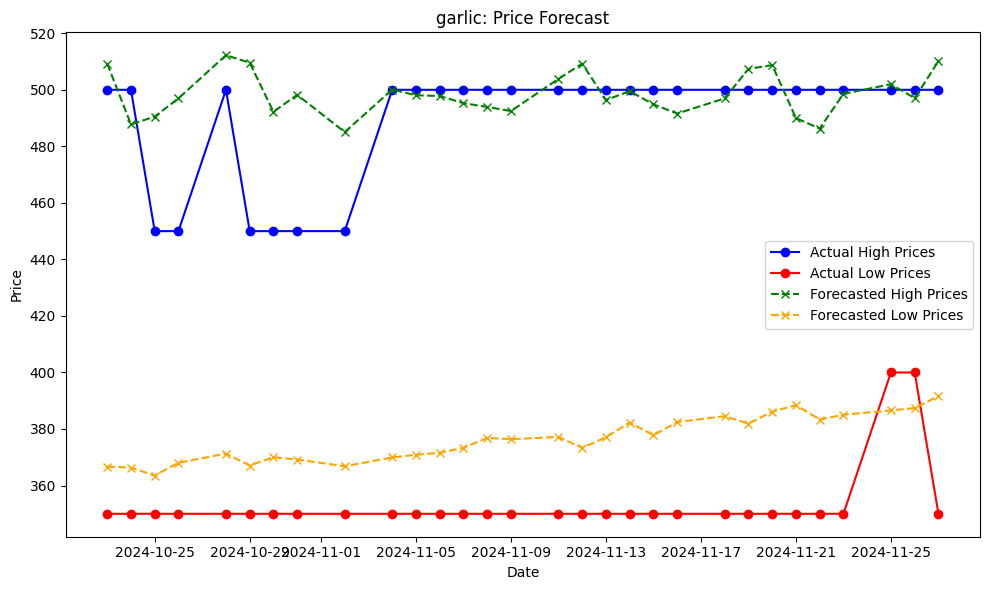

2024-12-18 20:34:53,771 - INFO - Completed all groups in 30.94 seconds.
2024-12-18 20:34:53,795 - INFO - All processing completed.


In [5]:
# Process all groups and output the results
mae_bic_results = process_all_groups(commodity_groups)
logging.info("All processing completed.")